In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np
import inspect

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info

In [3]:
print(inspect.getdoc(MovingAverage))
print('\n\nMain interface\n' + inspect.getdoc(MovingAverage.main))

Moving average filter
---------------------

Useful for cleaning noisy data (low-pass filter) and as an matched-filter for rectangular signals.

Args:
    window_len: Averaging window size, must be power of two. Determines the BRAM usage.
                For matched-filter, this must equal the samples-per-symbol.
    dtype: Sfix or Complex (applies to real and imag channels separately)


Main interface
Args:
    input (DataValid): -1.0 ... 1.0 range, up to 18 bits

Returns:
    DataValid: Accumulator scaled and rounded to 18 bits(-1.0 ... 1.0 range). Overflow impossible.


# Examples

## Noise removal

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 1024/1024 [00:00<00:00, 23517.83it/s]

INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 1022)
INFO:sim:Flush took 2 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


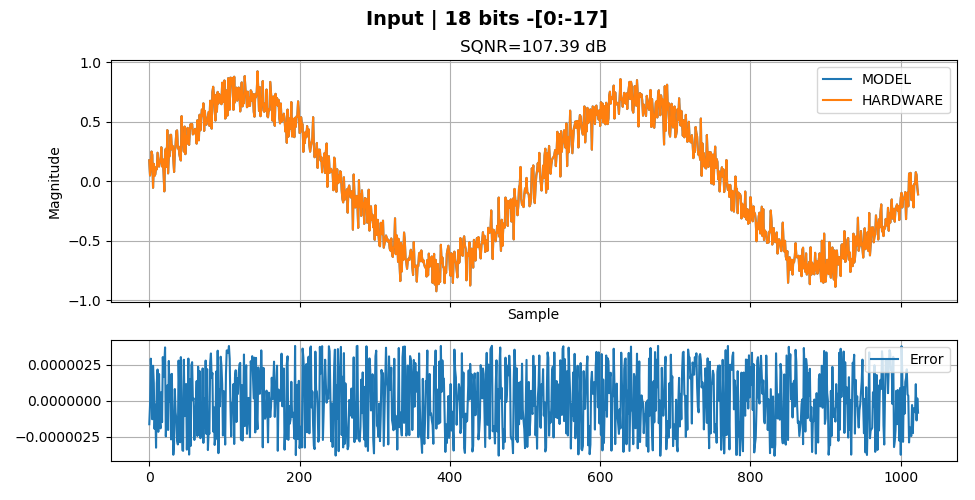

<IPython.core.display.Javascript object>


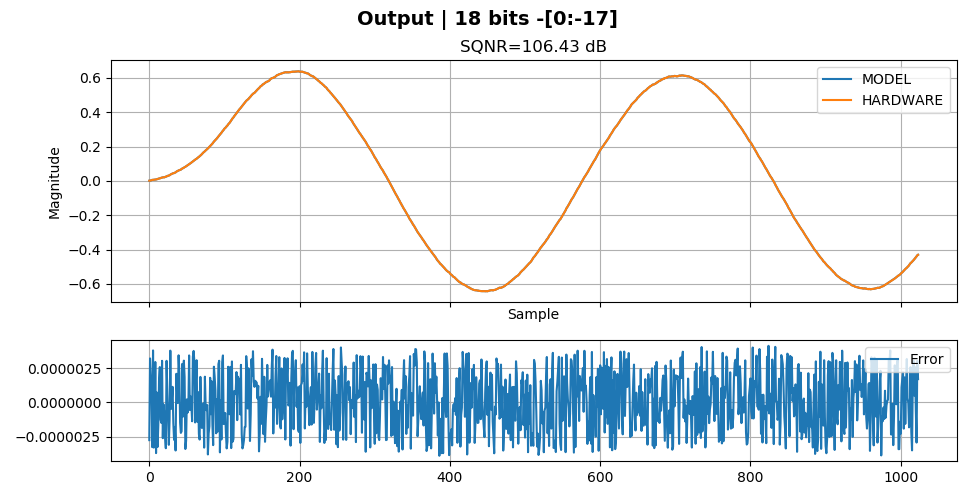

In [4]:
np.random.seed(0)
N = 1024
signal = 0.7*np.sin(np.linspace(0,2*2*np.pi,N))
noise = 0.1*np.random.normal(size=N)
input_signal = signal + noise # noisy input signal

dut = MovingAverage(window_len=128) # design we are testing
sims = simulate(dut, input_signal, trace=True, pipeline_flush='auto') # run simulations and gather trace
plot_trace()

## Frequency response

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 4096/4096 [00:00<00:00, 17289.69it/s]

INFO:sim:Flushing the pipeline to collect 4096 valid samples (currently have 4094)
INFO:sim:Flush took 2 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


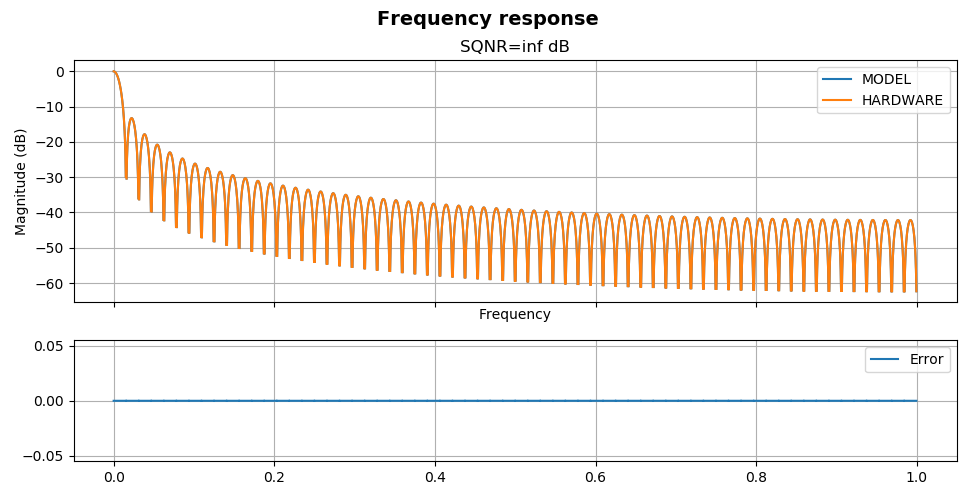

In [5]:
input_signal = [0.0] * 1024* 4
input_signal[0] = 1.0

dut = MovingAverage(window_len=128)
sims = simulate(dut, input_signal, trace=True, pipeline_flush='auto') # run simulations and gather trace
plot_frequency_response(sims)

## Matched filter

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 2048/2048 [00:00<00:00, 22849.95it/s]

INFO:sim:Flushing the pipeline to collect 2048 valid samples (currently have 2046)
INFO:sim:Flush took 2 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


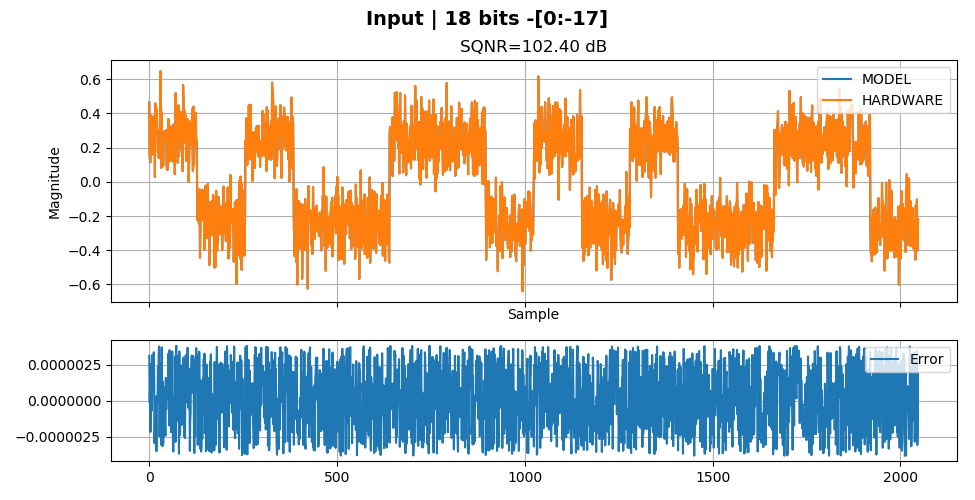

<IPython.core.display.Javascript object>


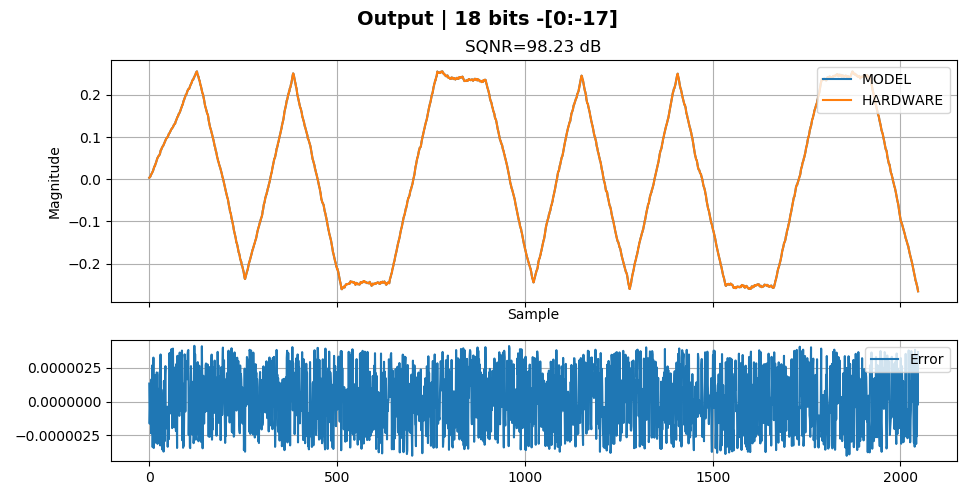

In [6]:
samples_per_bit = 128
bits = [1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
oversample = np.array([[x] * samples_per_bit for x in bits]).flatten()
input_signal = (oversample + np.random.normal(size=len(oversample))*0.5) * 0.25

dut = MovingAverage(window_len=samples_per_bit)
sims = simulate(dut, input_signal, trace=True, pipeline_flush='auto') # run simulations and gather trace
plot_trace()

# Conversion to VHDL and RTL/NETLIST simulations

In [7]:
# Pyha supports running 'RTL' (using GHDL) and 'NETLIST' (netlist after quartus_map) level simulations.
output_dir = '~/Documents/pyha_output'
input_signal = np.random.normal(size=512) * 0.25
dut = MovingAverage(window_len=128)
sims = simulate(dut, input_signal, pipeline_flush='auto', simulations=['MODEL', 'HARDWARE', 'RTL', 'NETLIST'], conversion_path=output_dir)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 512/512 [00:00<00:00, 3775.30it/s]

INFO:sim:Flushing the pipeline to collect 512 valid samples (currently have 510)
INFO:sim:Flush took 2 cycles.
INFO:sim:OK!
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...


INFO:conversion:DownCounter to VHDL ...
INFO:conversion:MovingAverage to VHDL ...
INFO:conversion:Took 0.29 seconds
INFO:sim:Running "RTL" simulation...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 514/514 [00:00<00:00, 4994.94it/s]

INFO:sim:OK!
INFO:sim:Running "NETLIST" simulation...
INFO:synth:Running quartus_map quartus_project...
INFO:synth:Running quartus_eda quartus_project...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 514/514 [00:00<00:00, 581.50it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


# Synthesis:  resource usage and Fmax

In [8]:
quartus = get_simulator_quartus() # reuse the work that was done during the simulation
print(quartus.get_resource_usage('fit'))
print(quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 114 / 39,600 ( < 1 % )
    Total combinational functions : 99 / 39,600 ( < 1 % )
    Dedicated logic registers : 78 / 39,600 ( < 1 % )
Total registers : 78
Total pins : 40 / 329 ( 12 % )
Total virtual pins : 0
Total memory bits : 2,250 / 1,161,216 ( < 1 % )
Embedded Multiplier 9-bit elements : 0 / 232 ( 0 % )
Total PLLs : 0 / 4 ( 0 % )

+--------------------------------------------------+
; Fmax Summary                                     ;
+------------+-----------------+------------+------+
; Fmax       ; Restricted Fmax ; Clock Name ; Note ;
+------------+-----------------+------------+------+
; 199.08 MHz ; 199.08 MHz      ; clk        ;      ;
+------------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by